In [1]:
from matplotlib import pyplot
import matplotlib
import pandas
from CO2_data_collector import CO2DataCollector

# Collect the data
In this section we show how to collect the emissions data for a given time period

In [2]:
collector = CO2DataCollector()

In [3]:
# Collects the data between two boundaries dates
collector.collect_data('2019-01-01', '2020-01-01')

In [4]:
# Generates a CSV file with the collected data
collector.generate_csv('Emissions_2019.csv')

# Data Cleaning
In this section we will perform some data cleaning since there are some corrupted data
that needs to be cleaned to convert the Fecha's column from string to a datetime object

In [35]:
dataset = pandas.read_csv('Emissions_2019.csv')

In [36]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 3 columns):
Unnamed: 0    52560 non-null int64
Fecha         52560 non-null object
Emisiones     52560 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB


Is there a problem with the data, on date 2019-10-27 on the interval from 02 to 03, it shows these values:
- 2019-10-27 2A:00
- 2019-10-27 2A:10
- 2019-10-27 2A:20
- 2019-10-27 2A:30
- 2019-10-27 2A:40
- 2019-10-27 2A:50
- 2019-10-27 2B:00
- 2019-10-27 2B:10
- 2019-10-27 2B:20
- 2019-10-27 2B:30
- 2019-10-27 2B:40
- 2019-10-27 2B:50

**Solution:**
- Drop rows which contain the letter 'B' in the Fecha's column
- In the rows where the date contains the characters 2A, replace these with 02

In [37]:
# Replace dates with 2A by 02
dataset['Fecha'] = dataset['Fecha'].str.replace('2A', '02')
# Use the NOT simbol (~) to return the dataset without these rows
dataset = dataset[~dataset.Fecha.str.contains("2B")]

In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52554 entries, 0 to 52559
Data columns (total 3 columns):
Unnamed: 0    52554 non-null int64
Fecha         52554 non-null object
Emisiones     52554 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


The number of instances now is 52554, so 6 rows have been removed

In [39]:
# Convert the column into a datetime object, the method detects the format automatically, if it does not, it can be custom formatted
dataset['Fecha'] = pandas.to_datetime(dataset['Fecha'])

In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52554 entries, 0 to 52559
Data columns (total 3 columns):
Unnamed: 0    52554 non-null int64
Fecha         52554 non-null datetime64[ns]
Emisiones     52554 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.6 MB


Now the 'Fecha' column is a datetime object

In [41]:
# Creates a new CSV with no data errors
dataset.to_csv("2019_Emissions_Clean.csv", index=False)

In [44]:
dataset = pandas.read_csv('2019_Emissions_Clean.csv', index_col=0)

In [45]:
dataset.head()

,Fecha,Emisiones
Unnamed: 0,,
0,2018-12-31 21:00:00,5053.99
1,2018-12-31 21:10:00,5114.81
2,2018-12-31 21:20:00,5098.81
3,2018-12-31 21:30:00,4979.55
4,2018-12-31 21:40:00,4851.19


In [ ]:
pyplot.figure(figsize=(20,10))
pyplot.plot_date(dataset['Fecha'], dataset['Emisiones'])

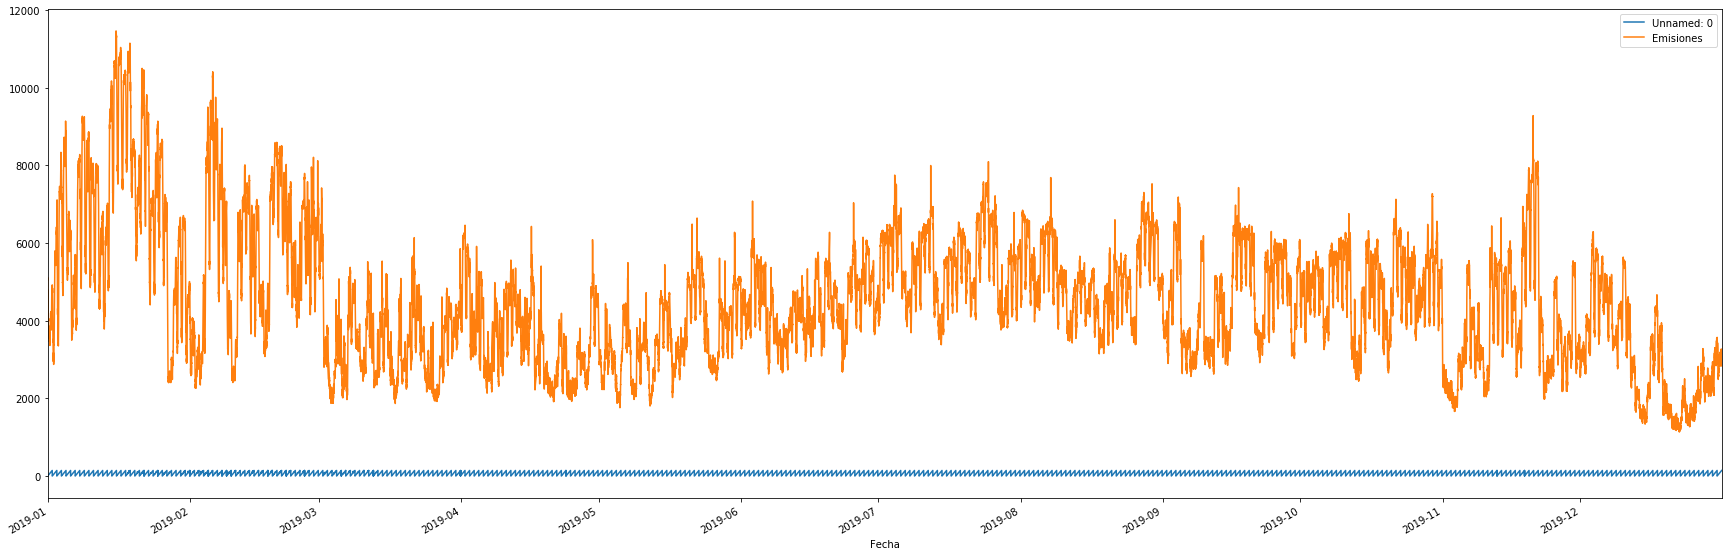

In [25]:
dataset.set_index('Fecha').plot(figsize=(30, 10))